# MPC COVID-19

Modelling and simulation of a COVID-19 compartmental system.

## Modelling

### Variables

| Variable       | Description                                 |
|:--------------:|:-------------------------------------------:|
| $P_k$          | Total individuals in age group $k$          |
| $S_k$          | Susceptible individuals from age group $k$  |
| $I_k$          | Infected individuals from age group $k$     |
| $R_k$          | Recovered individuals from age group $k$    |
| $D_k$          | Deceased individuals from age group $k$     |
| $U_k$          | Vaccination rate for age group $k$          |
| $\lambda_k$    | Infection rate for age group $k$            |
| $C_{j,k}$      | Contact rate between age groups $j$ and $k$ |
| $\gamma_{R,k}$ | Recovery rate for age group $k$             |
| $\gamma_{D,k}$ | Decease rate for age group $k$              |
| $n_a$          | Number of age groups                        |
| $\Delta_t$     | Sampling Period                             |

### Continous Model

$$
\left\{\begin{aligned}
\frac{d \, S_k(t)}{dt} &= -\lambda_k \, S_k(t) \, \sum_{j=1}^{n_a} C_{j,k} \, I_j(t) - U_k(t)
\\
\frac{d \, I_k(t)}{dt} &= \lambda_k \, S_k(t) \, \sum_{j=1}^{n_a} C_{k,j} \, I_j(t) - (\gamma_{R,k} + \gamma_{D,k}) \, I_k(t)
\\
\frac{d \, R_k(t)}{dt} &= \gamma_{R,k} \, I_k(t) + U_k(t)
\\
\frac{d \, D_k(t)}{dt} &= \gamma_{D,k} \, I_k(t)
\end{aligned}\right.
\;,\, k = 1, \dotsc, n_a
$$

### Discrete Model

$$
\left\{\begin{aligned}
S_k(n+1) &= S_k(n) + \Delta_t \, \left( -\lambda_k \, S_k(n) \, \sum_{j=1}^{n_a} C_{j,k} \, I_j(n) - U_k(n) \right)
\\
I_k(n+1) &= I_k(n) + \Delta_t \, \left( \lambda_k \, S_k(n) \, \sum_{j=1}^{n_a} C_{k,j} \, I_j(n) - (\gamma_{R,k} + \gamma_{D,k}) \, I_k(n) \right)
\\
R_k(n+1) &= R_k(n) + \Delta_t \, \left( \gamma_{R,k} \, I_k(n) + U_k(n) \right)
\\
D_k(n+1) &= D_k(n) + \Delta_t \, \left( \gamma_{D,k} \, I_k(n) \right)
\end{aligned}\right.
\;,\, k = 1, \dotsc, n_a
$$
Considering $\Delta_t = 1$
$$
\left\{\begin{aligned}
S_k(n+1) &= S_k(n) - \lambda_k \, S_k(n) \, \sum_{j=1}^{n_a} C_{j,k} \, I_j(n) - U_k(n)
\\
I_k(n+1) &= I_k(n) + \lambda_k \, S_k(n) \, \sum_{j=1}^{n_a} C_{k,j} \, I_j(n) - (\gamma_{R,k} + \gamma_{D,k}) \, I_k(n)
\\
R_k(n+1) &= R_k(n) + \gamma_{R,k} \, I_k(n) + U_k(n)
\\
D_k(n+1) &= D_k(n) + \gamma_{D,k} \, I_k(n)
\end{aligned}\right.
\;,\, k = 1, \dotsc, n_a
$$

## Pre-Simulation

### Definitions

In [1]:
import numpy as np
import csv

P = np.array([1058304,915796,983789,384803,203035,99516])
n_a = len(P)

I_0 = 0.1/100*P
S_0 = P - I_0
R_0 = np.zeros(n_a)
D_0 = np.zeros(n_a)

l   = np.repeat(0.05, n_a)
g_R = np.array([0.7657411   ,0.7842402  ,0.8012127 ,0.9018488 ,0.2802379 ,0.5864928 ])
g_D = np.array([0.0015683025,0.004833996,0.09288585,0.09685946,0.17079121,0.56594825])

with open("./contact.csv", 'r') as f:
  reader = csv.reader(f)
  data = list(reader)
C = np.array(data, dtype=float)

U_max = 55191

groups = ['[0,25)', '[25,45)', '[45,65)', '[65,75)', '[75,85)', '85+']

P_total = sum(P)
print(f'Population Total: {P_total:.0f}')

Population Total: 3645243


### Helpers

In [2]:
import matplotlib.pyplot as plt

def unwrap(y):
  S = y[0*n_a:1*n_a]
  I = y[1*n_a:2*n_a]
  R = y[2*n_a:3*n_a]
  D = y[3*n_a:4*n_a]
  return S, I, R, D

def wrap(S, I, R, D):
  return np.concatenate([S, I, R, D])

def plot(t, y, u, discrete=False):
  S, I, R, D = unwrap(y)

  fig, ax = plt.subplots(5, 2, figsize=(20,15), sharex=True)

  if discrete:
    ds = 'steps-post'
    step = 'post'
  else:
    ds = 'default'
    step = None

  for i in range(n_a):
    ax[0,0].plot(t, S[i], drawstyle=ds)
    ax[1,0].plot(t, I[i], drawstyle=ds)
    ax[2,0].plot(t, R[i], drawstyle=ds)
    ax[3,0].plot(t, D[i], drawstyle=ds)
    ax[4,0].plot(t, u[i], drawstyle=ds)

  ax[0,1].stackplot(t, S, step=step)
  ax[1,1].stackplot(t, I, step=step)
  ax[2,1].stackplot(t, R, step=step)
  ax[3,1].stackplot(t, D, step=step)
  ax[4,1].stackplot(t, u, step=step)

  for i in range(2):
    ax[0,i].set_ylabel('Susceptibles')
    ax[1,i].set_ylabel('Infected')
    ax[2,i].set_ylabel('Recovered')
    ax[3,i].set_ylabel('Deceased')
    ax[4,i].set_ylabel('Vaccination Rate')

  for ax_ in ax.flatten():
    ax_.set_xlim((t[0],t[-1]))
    ax_.grid()

  for ax_ in ax[-1,:]:
    ax_.set_xlabel('time')

  fig.tight_layout()
  fig.legend(groups, title='Age Group',ncols=n_a, loc="upper center", bbox_to_anchor=(0.5, 0))
  plt.show()

## Continous Simulation

### No Vaccination

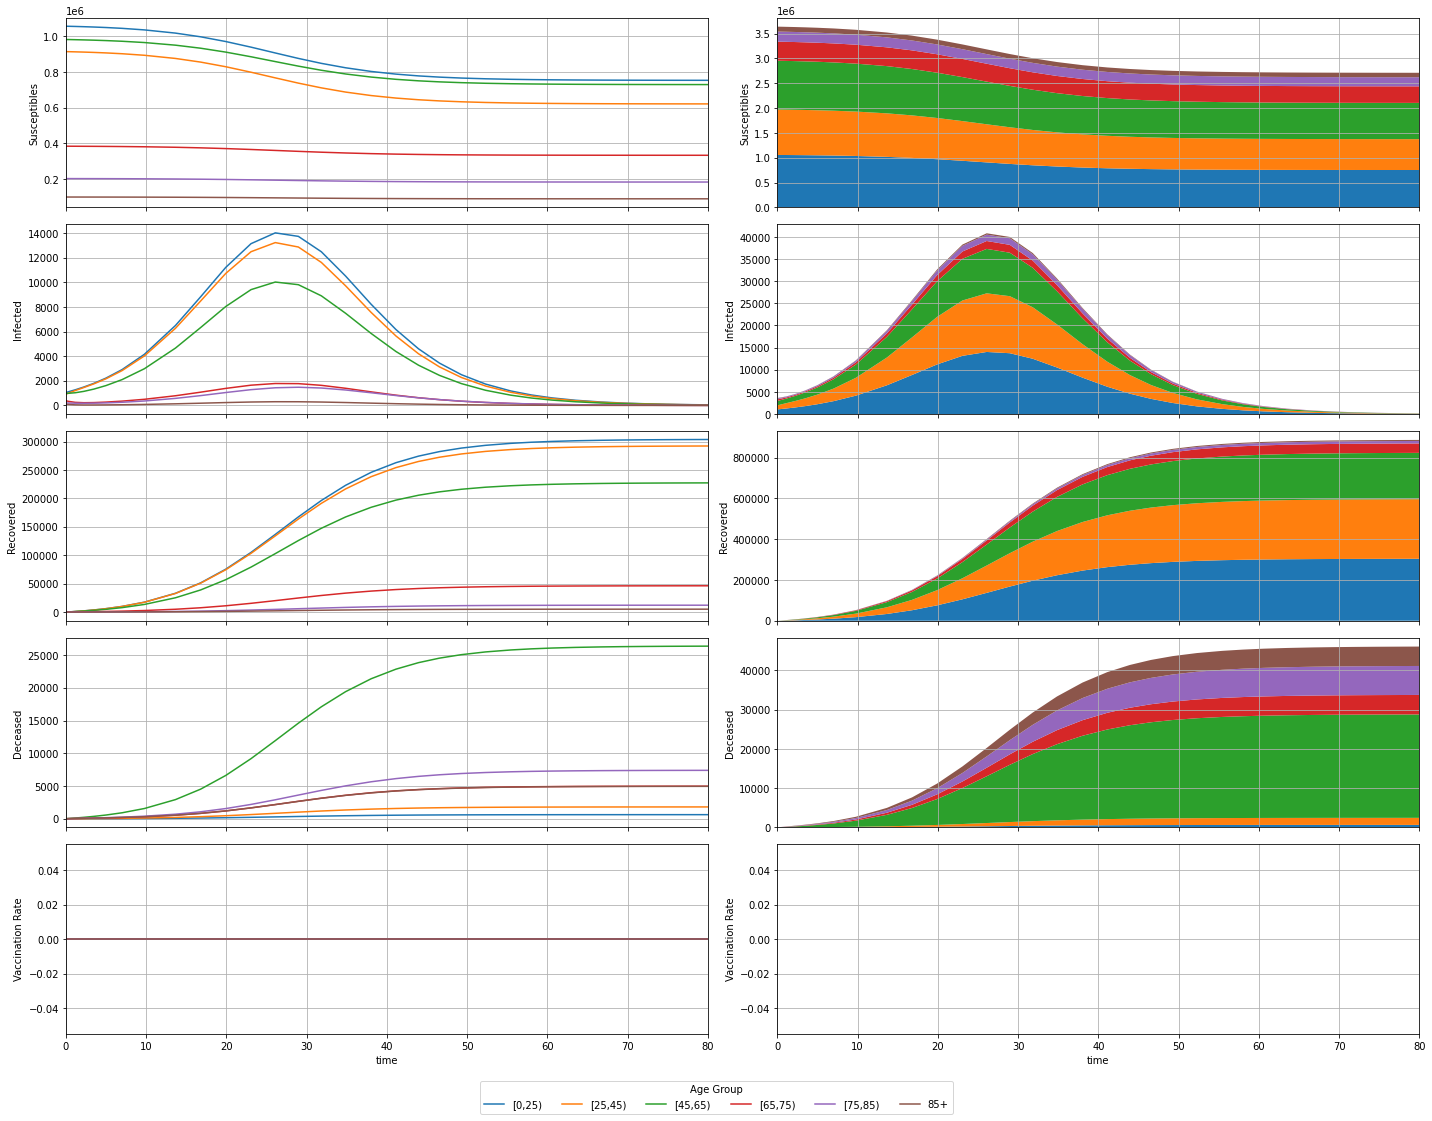

Deceased Total: 46089


In [3]:
from scipy.integrate import solve_ivp

def u(t, y):
  return np.zeros(n_a)

def system(t, y, l, C, g_R, g_D):
  S, I, R, D = unwrap(y)
  dSdt = - l * S * (C @ I) - u(t, y)
  dIdt = l * S * (C @ I) - (g_R + g_D) * I
  dRdt = g_R * I + u(t, y)
  dDdt = g_D * I
  return wrap(dSdt, dIdt, dRdt, dDdt)

t_span = [0, 80]
y_0 = wrap(S_0, I_0, R_0, D_0)

sol = solve_ivp(system, t_span, y_0, args=(l, C, g_R, g_D))
assert(sol.success)

t = sol.t
y = sol.y
S, I, R, D = unwrap(y)

U = np.zeros(S.shape)
for i, t_ in enumerate(t):
  y_ = y[:,i]
  U[:,i] = u(t_, y_)

plot(t, y, U)

D_total = sum(D[:,-1])
print(f'Deceased Total: {D_total:.0f}')

### Vaccination of Older Groups with Exclusivity

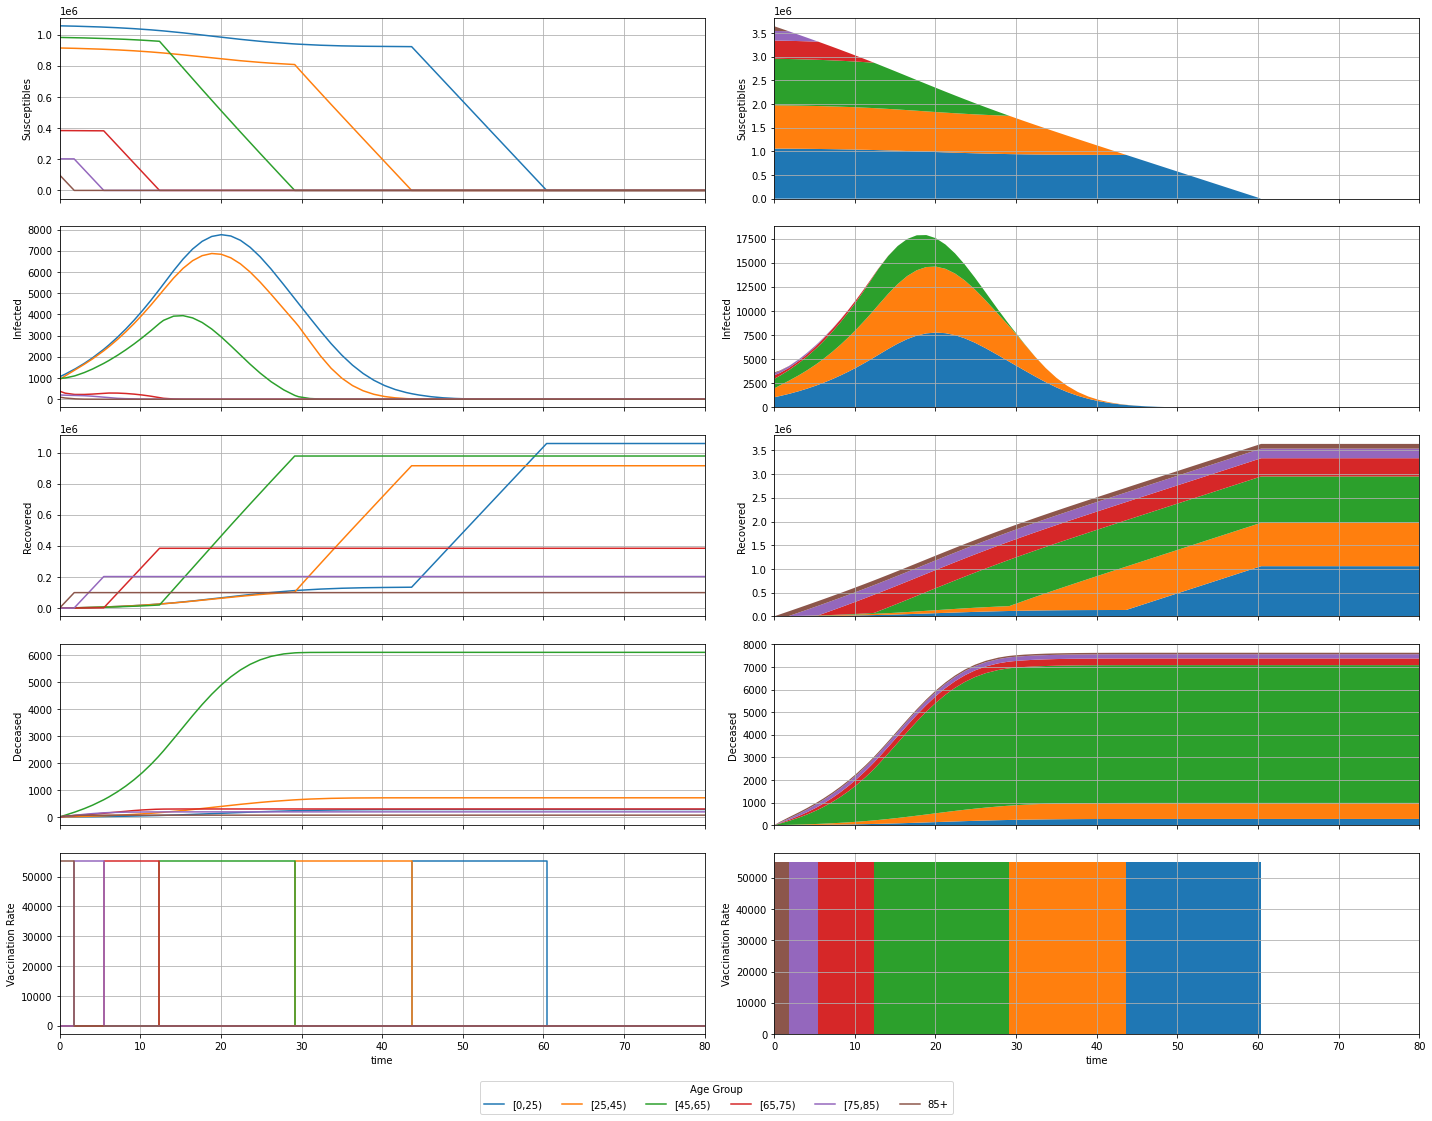

Deceased Total: 7633


In [4]:
from scipy.integrate import solve_ivp

def u(t, y):
  S, I, R, D = unwrap(y)
  u = np.zeros(n_a)
  for i in reversed(range(n_a)):
    if S[i] > 0:
      u[i] = U_max
      break
  return u

def system(t, y, l, C, g_R, g_D):
  S, I, R, D = unwrap(y)
  dSdt = - l * S * (C @ I) - u(t, y)
  dIdt = l * S * (C @ I) - (g_R + g_D) * I
  dRdt = g_R * I + u(t, y)
  dDdt = g_D * I
  return wrap(dSdt, dIdt, dRdt, dDdt)

t_span = [0, 80]
y_0 = wrap(S_0, I_0, R_0, D_0)

sol = solve_ivp(system, t_span, y_0, args=(l, C, g_R, g_D))
assert(sol.success)

t = sol.t
y = sol.y
S, I, R, D = unwrap(y)

U = np.zeros(S.shape)
for i, t_ in enumerate(t):
  y_ = y[:,i]
  U[:,i] = u(t_, y_)

plot(t, y, U)

D_total = sum(D[:,-1])
print(f'Deceased Total: {D_total:.0f}')

### Vaccination of Older Groups with Intersection

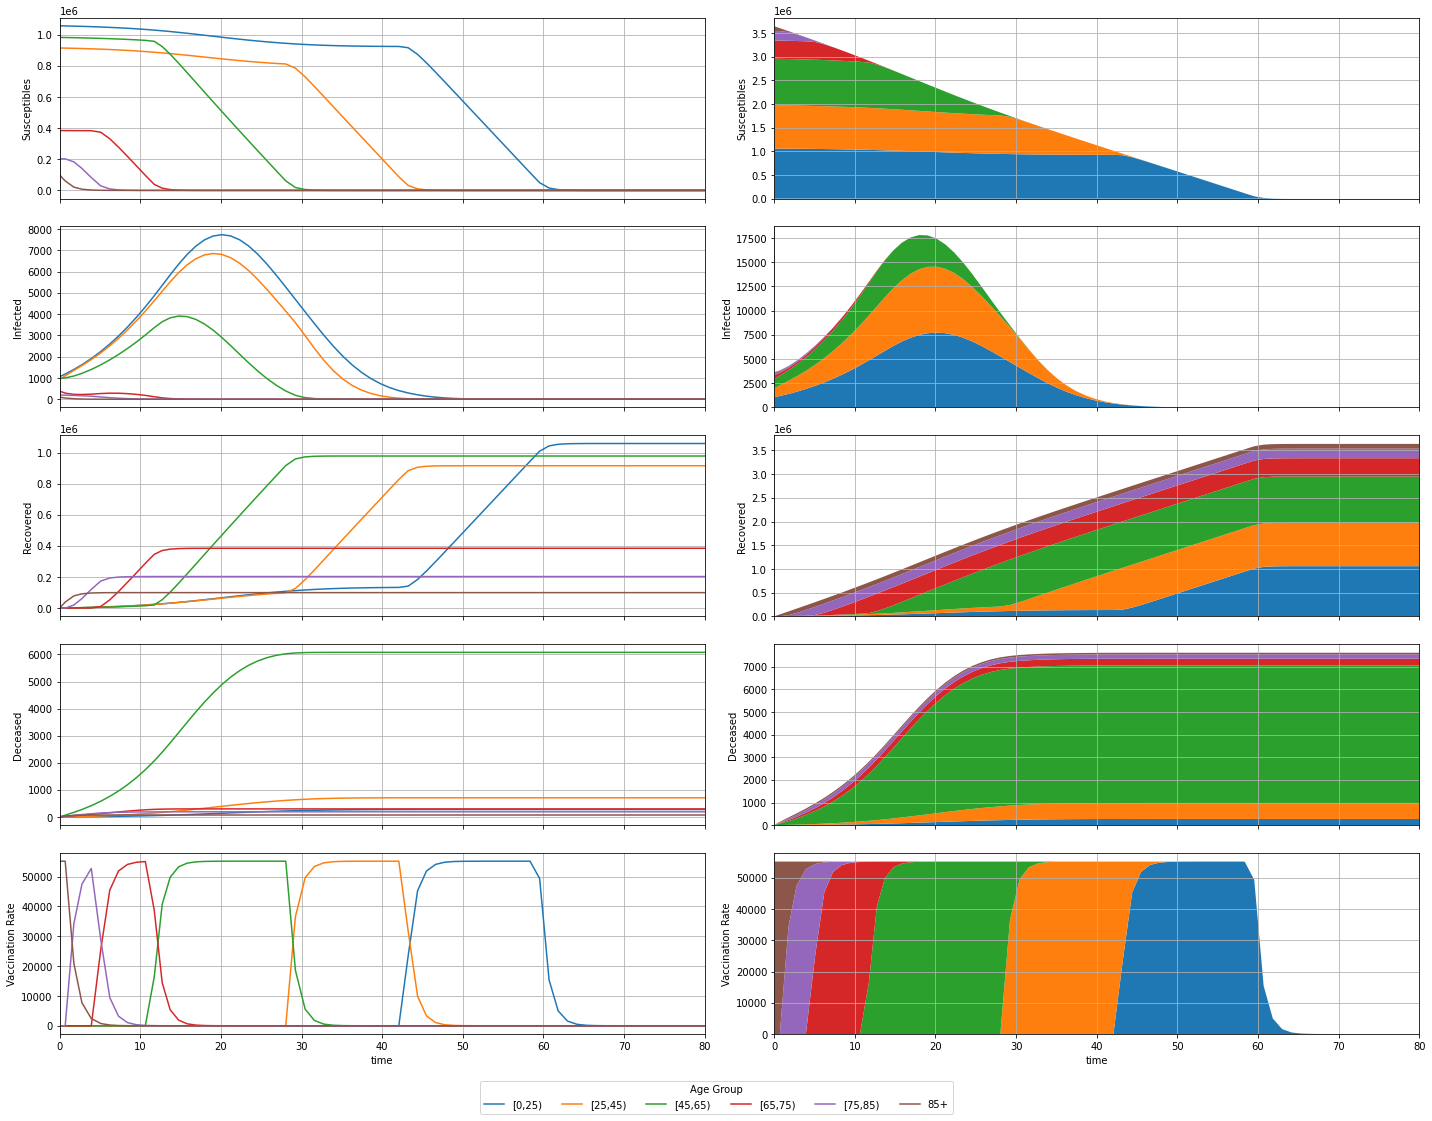

Deceased Total: 7616


In [5]:
from scipy.integrate import solve_ivp

def u(t, y):
  S, I, R, D = unwrap(y)
  u = np.zeros(n_a)
  remaining = U_max
  for i in reversed(range(n_a)):
    u[i] = min([S[i], remaining])
    remaining = remaining - u[i]
  return u

def system(t, y, l, C, g_R, g_D):
  S, I, R, D = unwrap(y)
  dSdt = - l * S * (C @ I) - u(t, y)
  dIdt = l * S * (C @ I) - (g_R + g_D) * I
  dRdt = g_R * I + u(t, y)
  dDdt = g_D * I
  return wrap(dSdt, dIdt, dRdt, dDdt)

t_span = [0, 80]
y_0 = wrap(S_0, I_0, R_0, D_0)

sol = solve_ivp(system, t_span, y_0, args=(l, C, g_R, g_D))
assert(sol.success)

t = sol.t
y = sol.y
S, I, R, D = unwrap(y)

U = np.zeros(S.shape)
for i, t_ in enumerate(t):
  y_ = y[:,i]
  U[:,i] = u(t_, y_)

plot(t, y, U)

D_total = sum(D[:,-1])
print(f'Deceased Total: {D_total:.0f}')

## Discrete Simulation

### No Vaccination

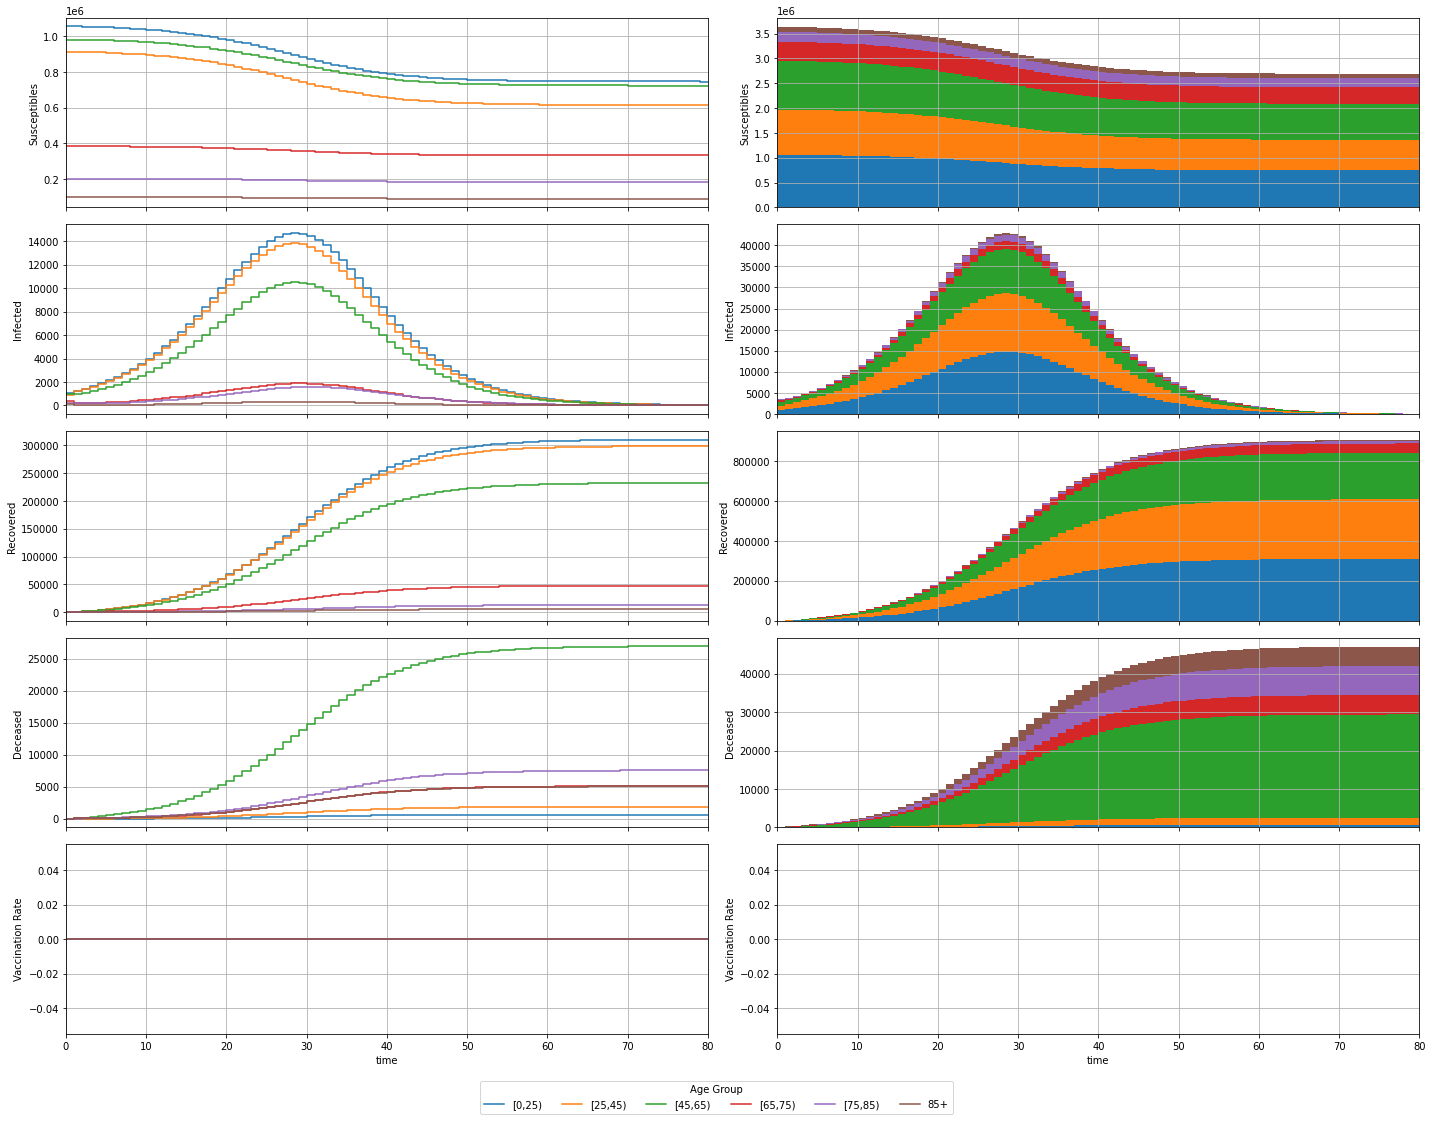

Deceased Total: 47115


In [6]:
def u(t, y):
  return np.zeros(n_a)

def system(t, y, l, C, g_R, g_D):
  S, I, R, D = unwrap(y)
  S_ = S - l * S * (C @ I) - u(t, y)
  I_ = I + l * S * (C @ I) - (g_R + g_D) * I
  R_ = R + g_R * I + u(t, y)
  D_ = D + g_D * I
  return wrap(S_, I_, R_, D_)

t = np.linspace(0, 80, 81)
y_0 = wrap(S_0, I_0, R_0, D_0)

y = np.empty((4*n_a,81))
for i, t_ in enumerate(t):
  if i == 0:
    y[:,i] = y_0
  else:
    y[:,i] = system(t_, y[:,i-1], l, C, g_R, g_D)

S, I, R, D = unwrap(y)

U = np.zeros(S.shape)
for i, t_ in enumerate(t):
  y_ = y[:,i]
  U[:,i] = u(t_, y_)

plot(t, y, U, discrete=True)

D_total = sum(D[:,-1])
print(f'Deceased Total: {D_total:.0f}')

### Vaccination of Older Groups

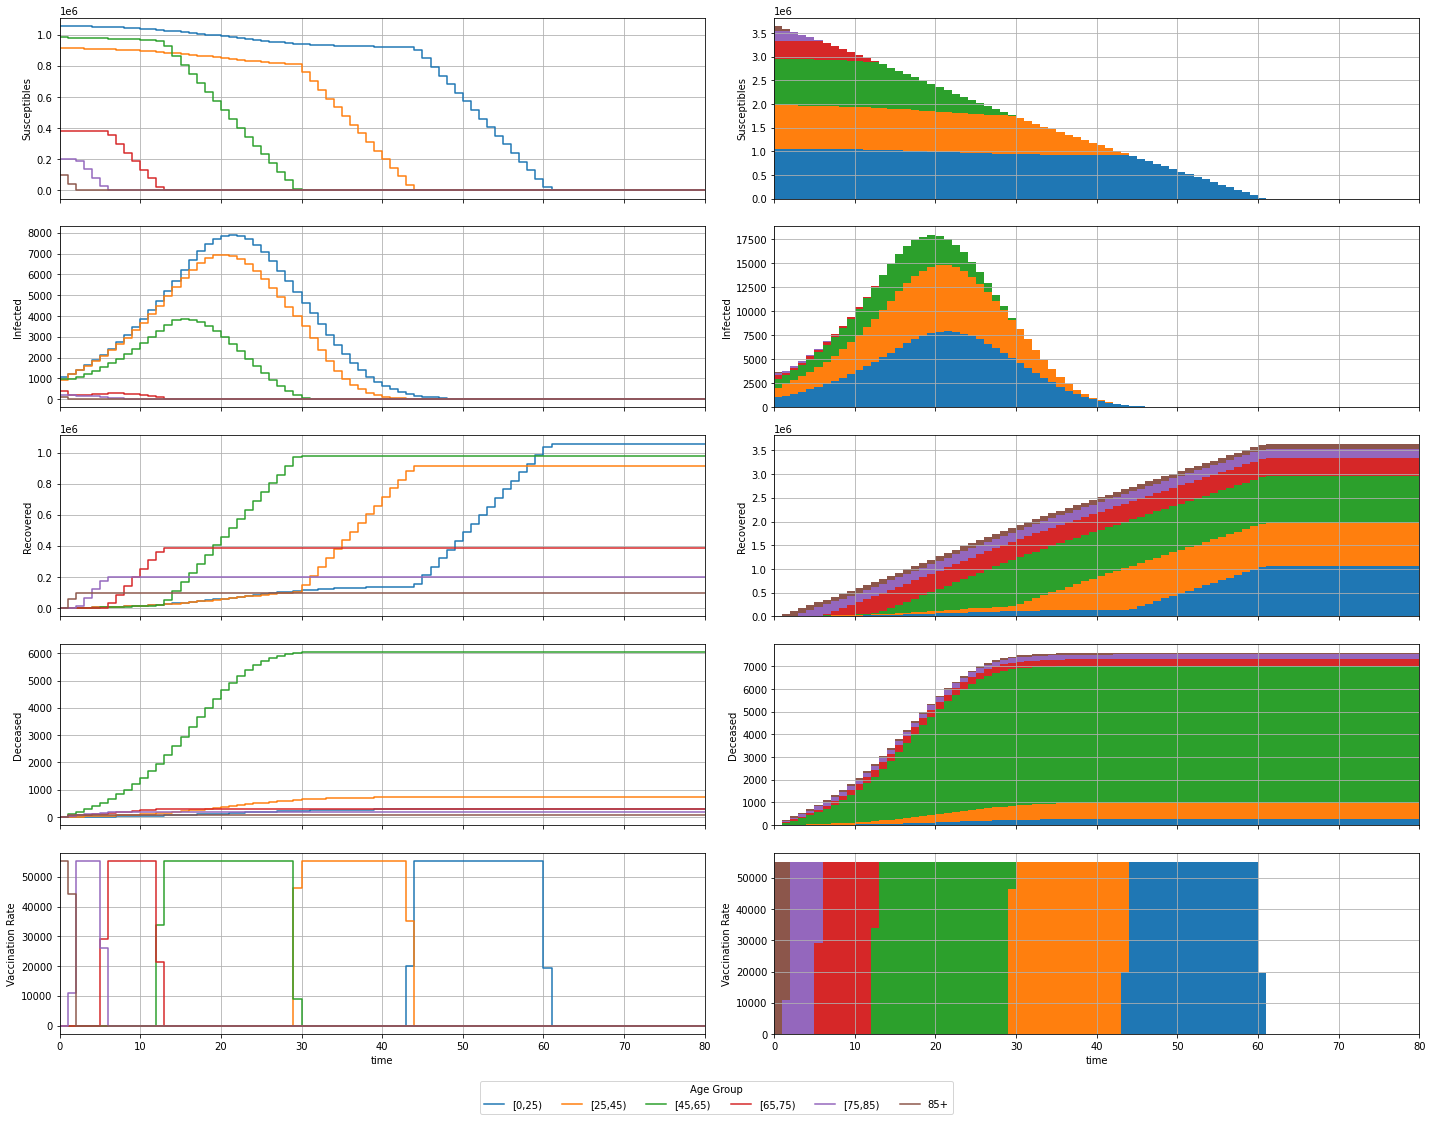

Deceased Total: 7593


In [7]:
def u(t, y):
  S, I, R, D = unwrap(y)
  u = np.zeros(n_a)
  remaining = U_max
  for i in reversed(range(n_a)):
    u[i] = min([S[i], remaining])
    remaining = remaining - u[i]
  return u


def system(t, y, l, C, g_R, g_D):
  S, I, R, D = unwrap(y)
  S_ = S - l * S * (C @ I) - u(t, y)
  I_ = I + l * S * (C @ I) - (g_R + g_D) * I
  R_ = R + g_R * I + u(t, y)
  D_ = D + g_D * I
  return wrap(S_, I_, R_, D_)

t = np.linspace(0, 80, 81)
y_0 = wrap(S_0, I_0, R_0, D_0)

y = np.empty((4*n_a,81))
for i, t_ in enumerate(t):
  if i == 0:
    y[:,i] = y_0
  else:
    y[:,i] = system(t_, y[:,i-1], l, C, g_R, g_D)

S, I, R, D = unwrap(y)

U = np.zeros(S.shape)
for i, t_ in enumerate(t):
  y_ = y[:,i]
  U[:,i] = u(t_, y_)

plot(t, y, U, discrete=True)

D_total = sum(D[:,-1])
print(f'Deceased Total: {D_total:.0f}')